In [2]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from datasets import load_from_disk, load_dataset
from pathlib import Path
import matplotlib.pyplot as plt
import torch

In [3]:
project_root = Path.cwd().parent
data_path = project_root / "data"  / "validation"


dataset = load_dataset("flaviagiammarino/path-vqa", split="validation")
sample = dataset[5444]  
image = sample["image"] 
question = sample["question"]
answer = sample["answer"]

In [4]:
def resize_with_aspect_ratio(img, max_size=384):
    """
    Skaliert das Bild so, dass die größte Seite 'max_size' ist,
    Seitenverhältnis bleibt erhalten.
    """
    w, h = img.size
    scale = max_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    return img.resize((new_w, new_h))

# Anwendung:
image = resize_with_aspect_ratio(image, max_size=384)



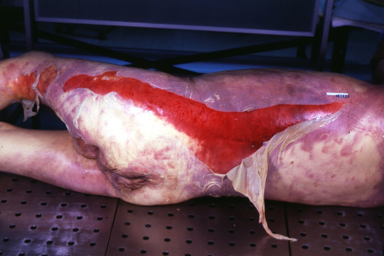

In [4]:
image

In [5]:
question

'does underdevelopment show body with extensive ecchymoses and desquamation?'

In [6]:
answer

'no'

In [5]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"  # damit output_attentions weiter funktioniert
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
model.eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger(
  

In [7]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question}
        ]
    }
]

In [8]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [9]:
image_inputs, video_inputs = process_vision_info(messages)

In [10]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    truncation=True,          # <-- GANZ WICHTIG
    max_length=1024,           # <-- Setze max_length klein!
    return_tensors="pt"
).to(model.device)


In [11]:
outputs = model(
    **inputs,
    output_attentions=True,
    return_dict=True
)

In [12]:
attn_last_layer = outputs.attentions[-1][0]      # Shape: (heads, seq_len, seq_len)
attn_avg = attn_last_layer.mean(dim=0).detach().cpu().float().numpy()
 # (seq_len, seq_len)


In [13]:
token_ids = inputs["input_ids"][0]  # Tensor Länge seq_len
tokens = processor.tokenizer.convert_ids_to_tokens(token_ids.cpu().tolist())


In [16]:
attn_avg

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.90625000e-01, 6.09375000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.85937500e-02, 7.42187500e-02, 8.67187500e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.69970703e-03, 5.98907471e-04, 1.19628906e-01, ...,
        9.37500000e-02, 0.00000000e+00, 0.00000000e+00],
       [8.17871094e-03, 2.33459473e-03, 1.21582031e-01, ...,
        2.31933594e-02, 1.43554688e-01, 0.00000000e+00],
       [5.00488281e-03, 1.31225586e-03, 9.86328125e-02, ...,
        2.39257812e-02, 4.34570312e-02, 2.67578125e-01]], dtype=float32)

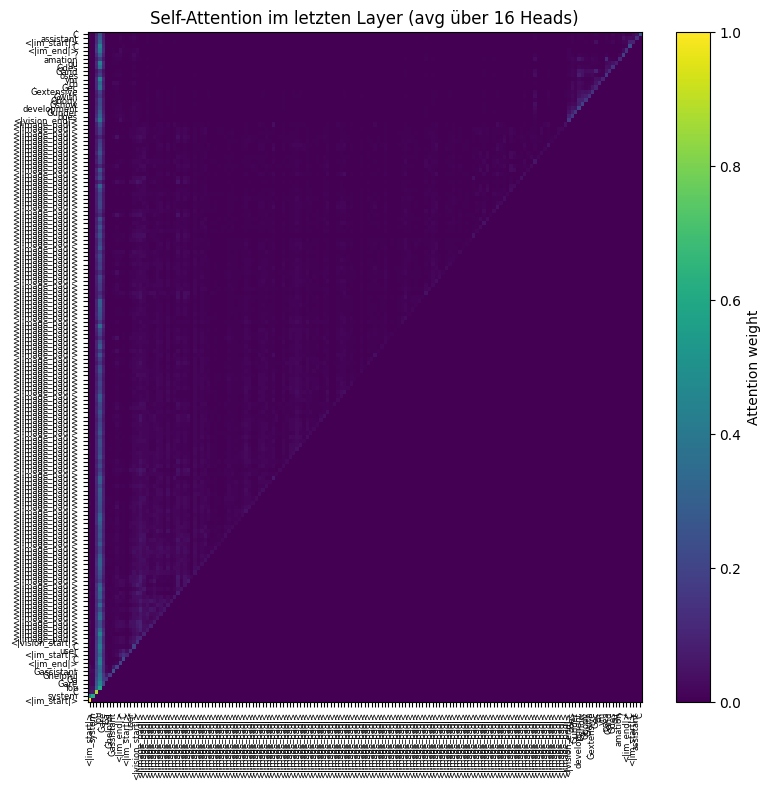

In [17]:
# 4) Plot als Heatmap
plt.figure(figsize=(8, 8))
plt.imshow(attn_avg, origin="lower", aspect="auto")
plt.colorbar(label="Attention weight")

# x-Achse: Keys (wo schau ich hin), y-Achse: Queries (was generiere ich)
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=6)
plt.yticks(range(len(tokens)), tokens, fontsize=6)

plt.title(f"Self-Attention im letzten Layer (avg über {attn_last_layer.shape[0]} Heads)")
plt.tight_layout()
plt.show()

# über verschiedene heads den plot zu zeigen

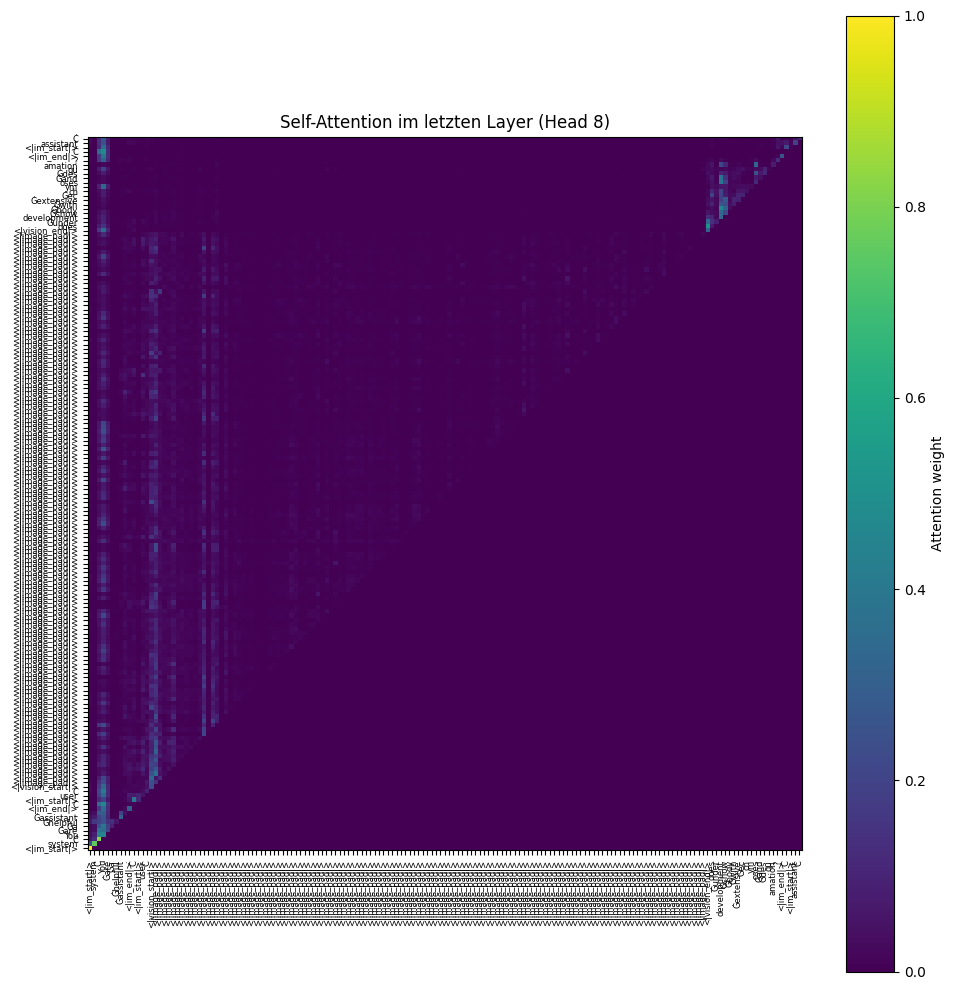

In [54]:
# Wähle einen bestimmten Head (z. B. Head 0) MAX BIS 15
head = 8
attn_head = attn_last_layer[head].detach().cpu().float().numpy()  # Shape: (seq_len, seq_len)

# Heatmap für diesen Head
plt.figure(figsize=(10, 10))
plt.imshow(attn_head, origin="lower", cmap="viridis", vmin=0, vmax=attn_head.max())
plt.colorbar(label="Attention weight")
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=6)
plt.yticks(range(len(tokens)), tokens, fontsize=6)
plt.title(f"Self-Attention im letzten Layer (Head {head})")
plt.tight_layout()
plt.show()

# Self attention mit logarithmierten werten für bessere darstellung

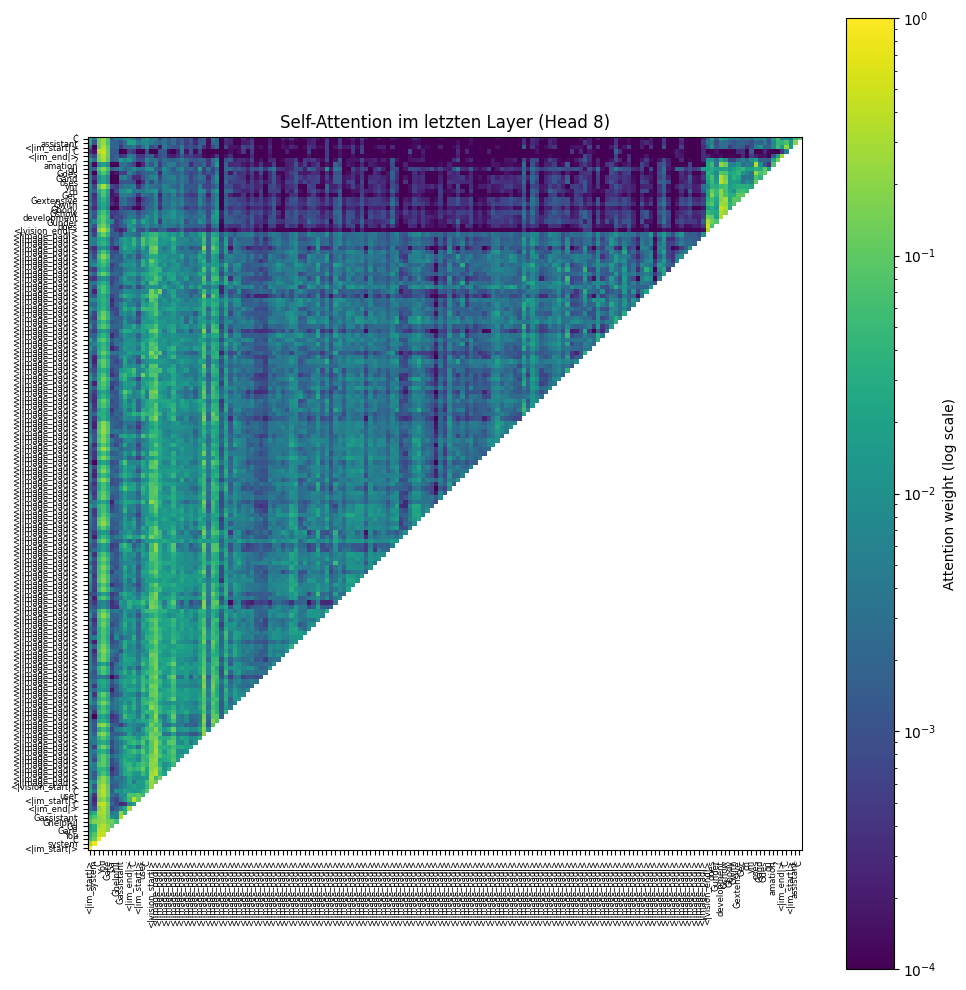

In [55]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 10))
plt.imshow(attn_head, origin="lower", cmap="viridis", norm=LogNorm(vmin=1e-4, vmax=attn_head.max()))
plt.colorbar(label="Attention weight (log scale)")
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=6)
plt.yticks(range(len(tokens)), tokens, fontsize=6)
plt.title(f"Self-Attention im letzten Layer (Head {head})")
plt.tight_layout()
plt.show()

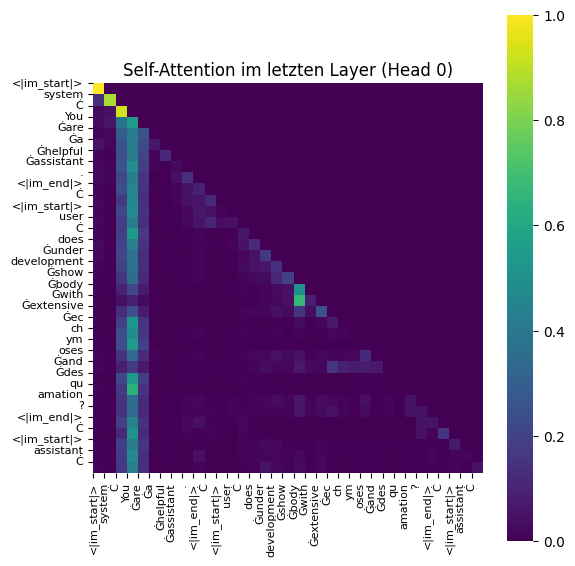

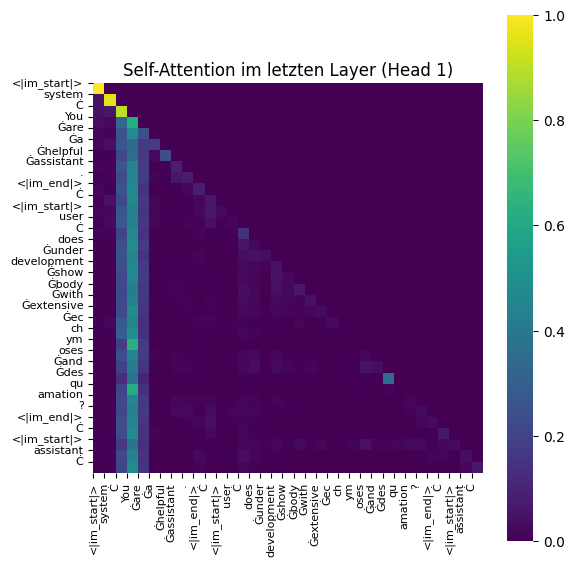

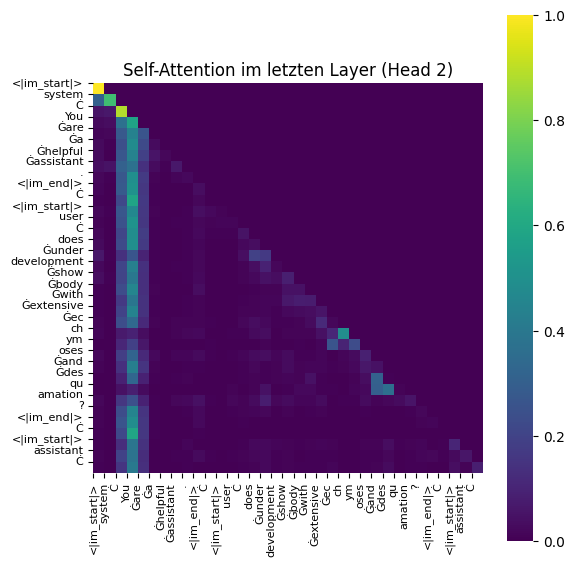

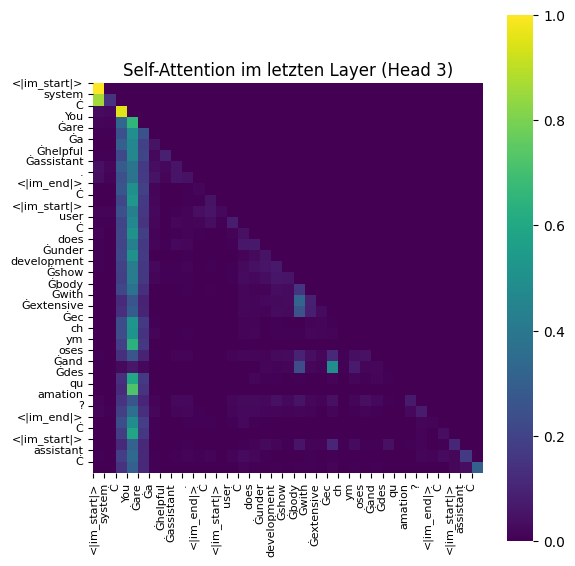

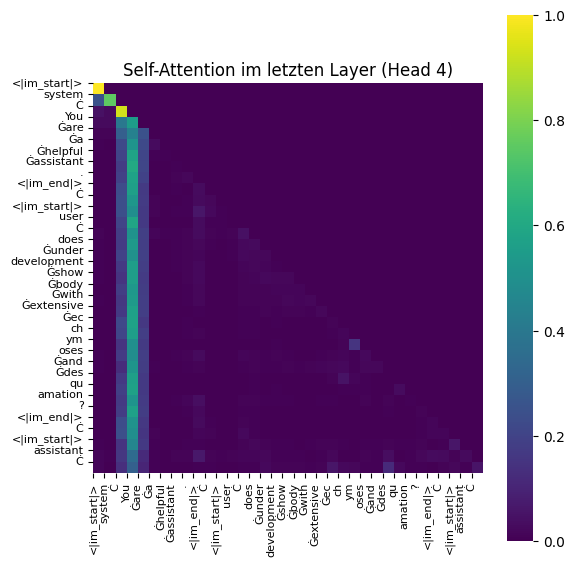

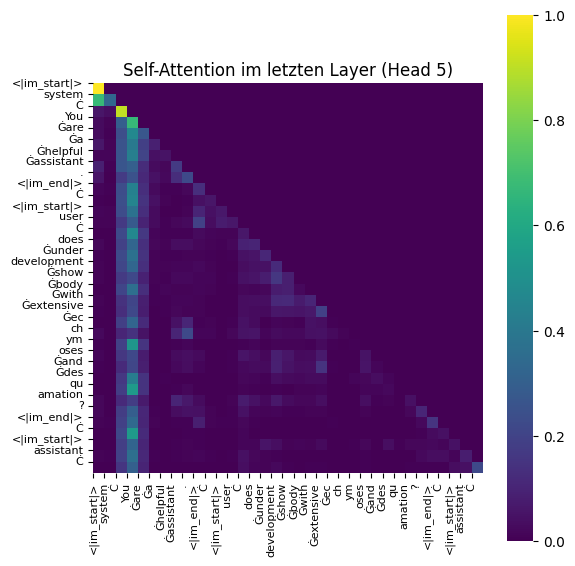

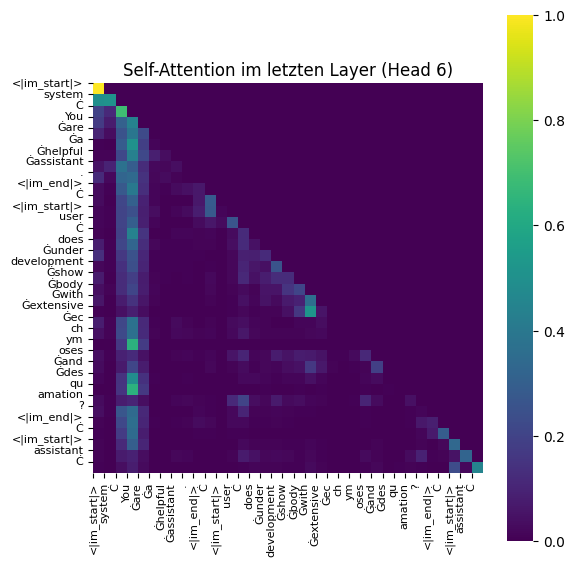

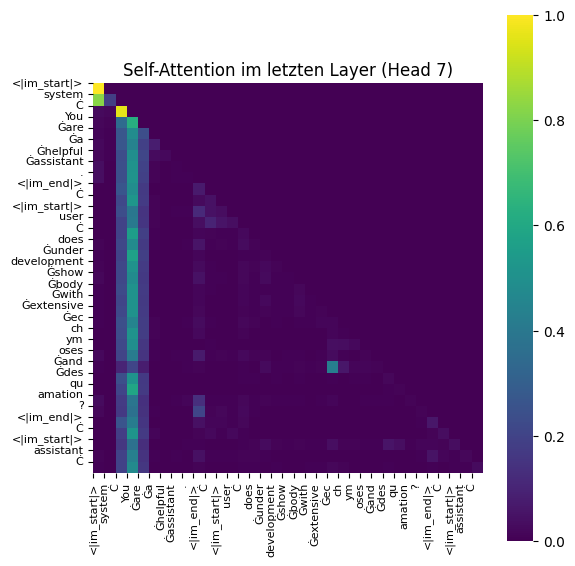

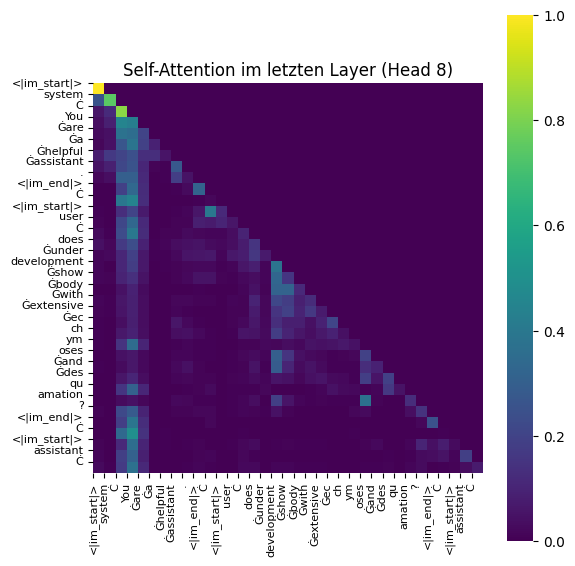

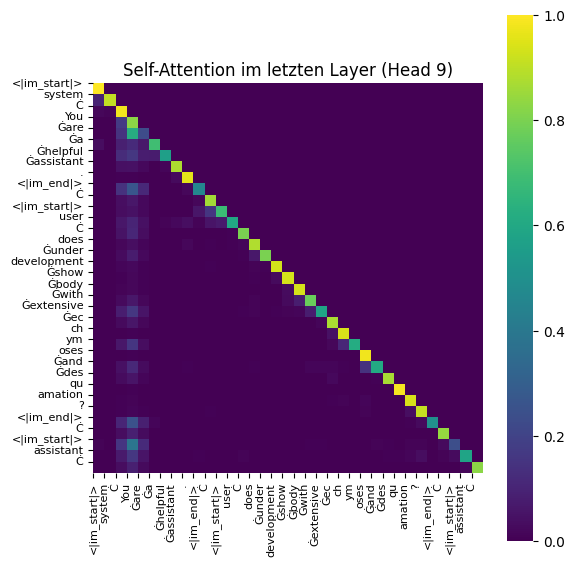

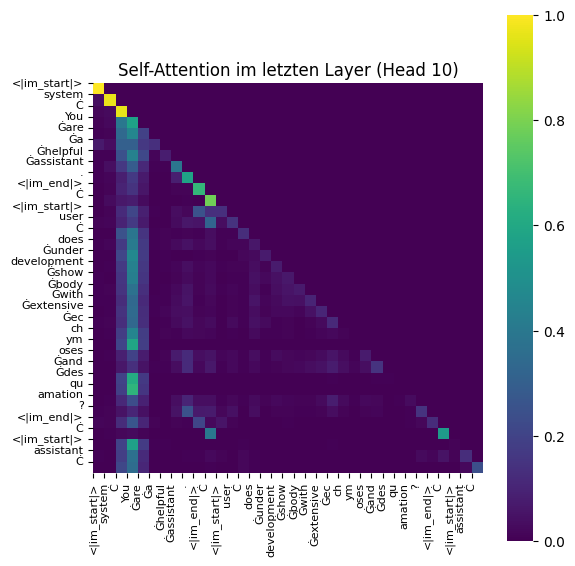

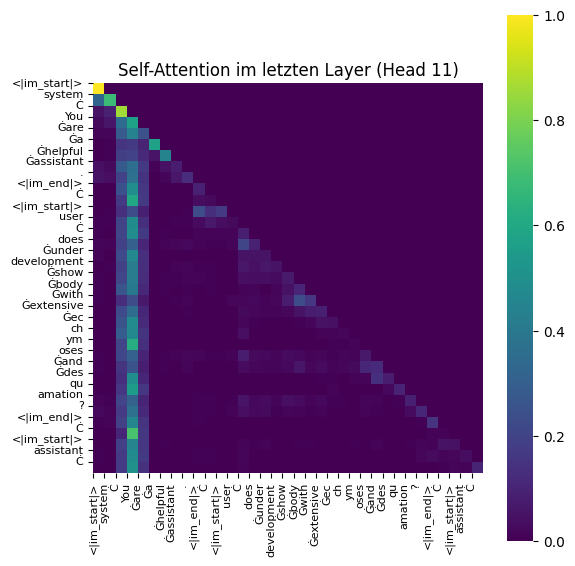

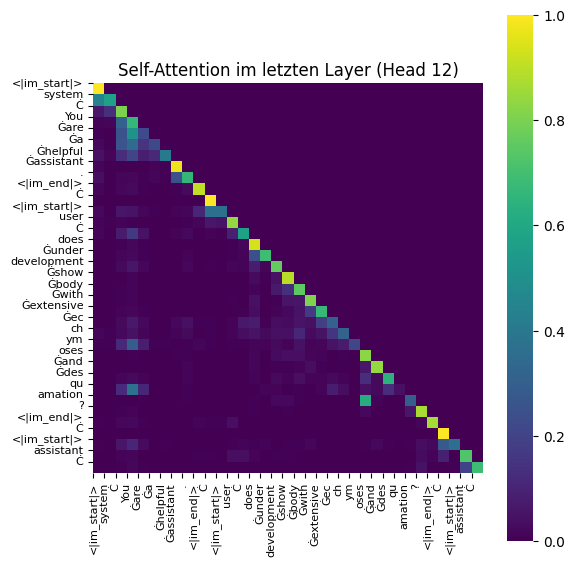

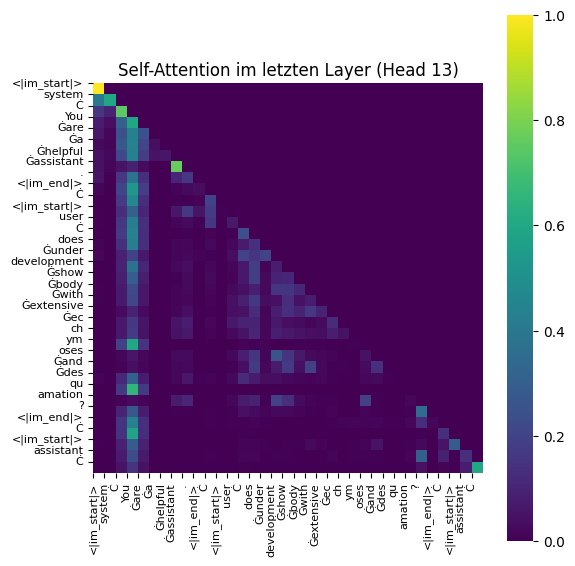

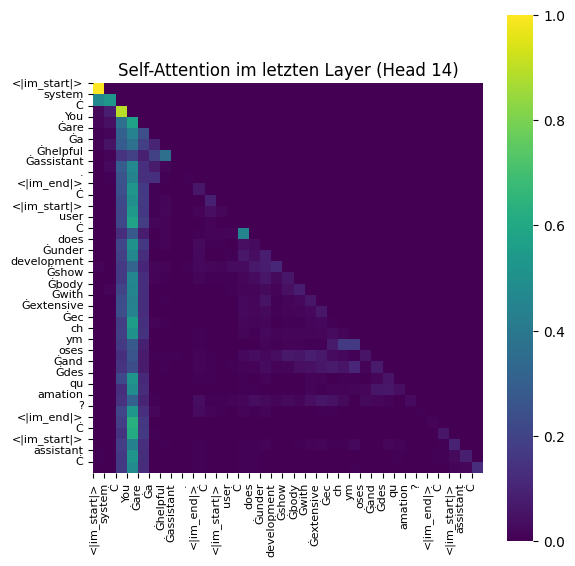

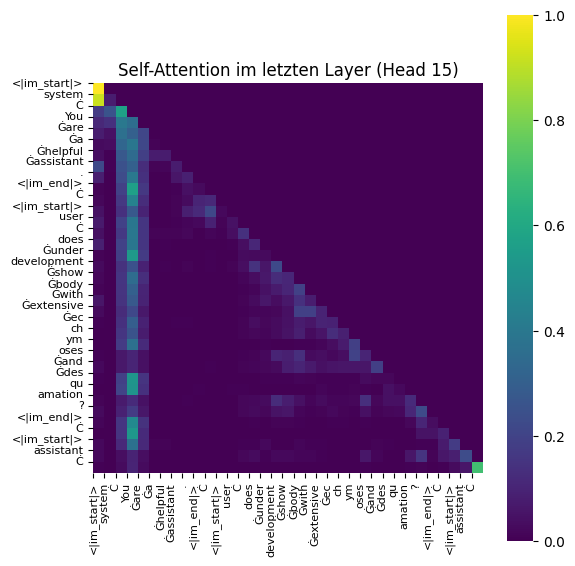

In [19]:
import seaborn as sns

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": question}
        ]
    }
]

# Text verarbeiten (ohne Bild)
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[text],
    padding=True,
    truncation=True,
    max_length=128,  # Reduziere max_length für Text
    return_tensors="pt"
).to(model.device)

# Modell ausführen
outputs = model(
    **inputs,
    output_attentions=True,
    return_dict=True
)

# Attention-Gewichte des letzten Layers
attn_last_layer = outputs.attentions[-1][0]  # Shape: (heads, seq_len, seq_len)

# Token-IDs und -Namen extrahieren
token_ids = inputs["input_ids"][0]
tokens = processor.tokenizer.convert_ids_to_tokens(token_ids.cpu().tolist())

# Nur Text-Token berücksichtigen (volle Länge der Sequenz)
seq_len = len(tokens)

# Attention-Matrix für jeden Head visualisieren
for head in range(attn_last_layer.shape[0]):
    attn_head = attn_last_layer[head].detach().cpu().float().numpy()[:seq_len, :seq_len]  # Nur Text-Token

    plt.figure(figsize=(6, 6))
    sns.heatmap(attn_head, cmap="viridis", vmin=0, vmax=attn_head.max(), square=True)
    plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8)
    plt.yticks(range(len(tokens)), tokens, rotation=0, fontsize=8)
    plt.title(f"Self-Attention im letzten Layer (Head {head})")
    plt.tight_layout()
    plt.show()

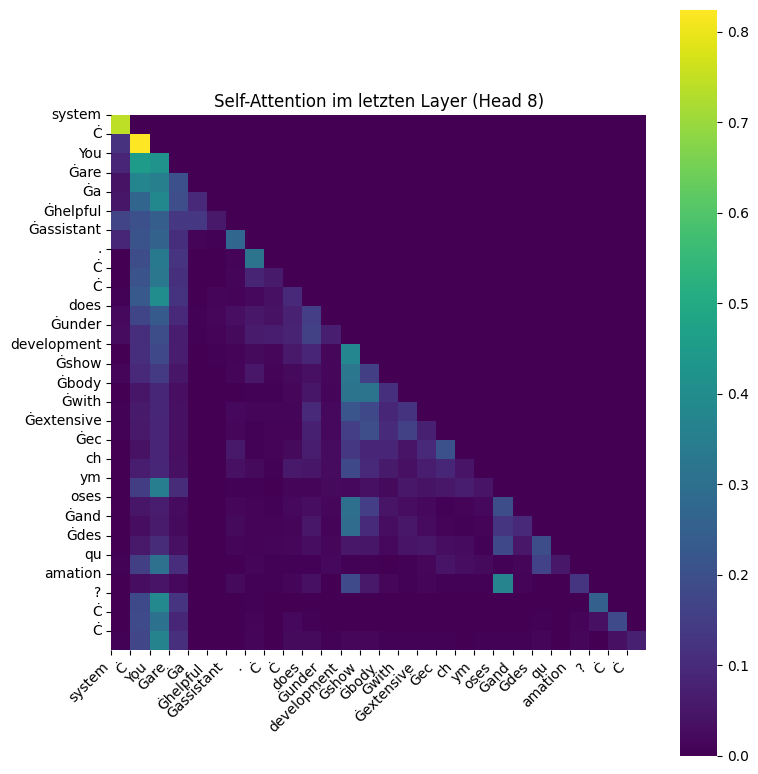

In [16]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": question}
        ]
    }
]

# Text verarbeiten
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[text],
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
).to(model.device)

# Modell ausführen
outputs = model(
    **inputs,
    output_attentions=True,
    return_dict=True
)

# Attention-Gewichte des letzten Layers
attn_last_layer = outputs.attentions[-1][0]  # Shape: (heads, seq_len, seq_len)

# Token-IDs und -Namen extrahieren
token_ids = inputs["input_ids"][0]
raw_tokens = processor.tokenizer.convert_ids_to_tokens(token_ids.cpu().tolist())

# Steuer-Token entfernen und Subword-Token zusammenführen
special_tokens = ['<|im_start|>', '<|im_end|>', 'sys', 'user', 'assistant', '<|endoftext|>']
cleaned_tokens = []
cleaned_indices = []
current_word = ""
for i, token in enumerate(raw_tokens):
    if token in special_tokens:
        continue  # Steuer-Token überspringen
    if token.startswith('##'):  # Subword-Token
        current_word += token[2:]  # ## entfernen und anhängen
    else:
        if current_word:  # Vorheriges Wort speichern
            cleaned_tokens.append(current_word)
            cleaned_indices.append(i-1)
        current_word = token
    if i == len(raw_tokens) - 1 and current_word:  # Letztes Wort
        cleaned_tokens.append(current_word)
        cleaned_indices.append(i)

# Attention-Matrix auf die relevanten Indizes einschränken
attn_cleaned = attn_last_layer[:, cleaned_indices, :][:, :, cleaned_indices]

# Visualisierung für Head 8
head = 8
attn_head = attn_cleaned[head].detach().cpu().float().numpy()

plt.figure(figsize=(8, 8))
sns.heatmap(attn_head, cmap="viridis", vmin=0, vmax=attn_head.max(), square=True)
plt.xticks(range(len(cleaned_tokens)), cleaned_tokens, rotation=45, fontsize=10, ha='right')
plt.yticks(range(len(cleaned_tokens)), cleaned_tokens, fontsize=10)
plt.title(f"Self-Attention im letzten Layer (Head {head})")
plt.tight_layout()
plt.show()

Neuer Versuch nur mit Text

In [18]:
import numpy as np

# 1) Hole alle special IDs (inkl. PAD, BOS, EOS, Image-Tokens, …)
special_ids = set(processor.tokenizer.all_special_ids)

In [19]:
# 2) Baue eine Maske über alle Token-Positionen:
token_ids = inputs["input_ids"][0].cpu().tolist()
mask = [tid not in special_ids for tid in token_ids]

In [20]:
attn_text = attn_avg[np.ix_(mask, mask)]   # nur die nicht-special IDs

In [21]:
tokens_all = processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens_txt = [tok for tok, m in zip(tokens_all, mask) if m]

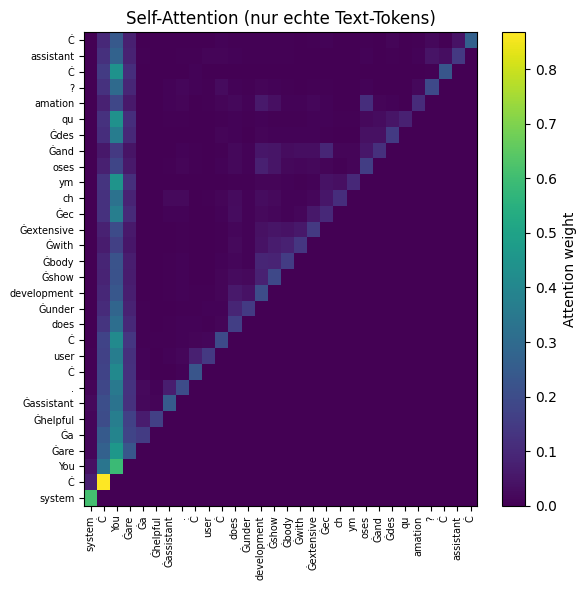

In [22]:
# 5) Plot neu – nur Text-Tokens!
plt.figure(figsize=(6,6))
plt.imshow(attn_text, origin="lower", aspect="auto")
plt.colorbar(label="Attention weight")

plt.xticks(range(len(tokens_txt)), tokens_txt, rotation=90, fontsize=7)
plt.yticks(range(len(tokens_txt)), tokens_txt, fontsize=7)

plt.title("Self-Attention (nur echte Text-Tokens)")
plt.tight_layout()
plt.show()

# Jetzt Frage plus Antwort

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Länge des reinen Prompt-Inputs
prompt_len = inputs["input_ids"].shape[1]

# 2) Baue das vollständige Chat-Template mit Prompt + Antwort
messages_full = [
    {"role":"user", "content":[
        {"type":"image","image":image},
        {"type":"text", "text": question}
    ]},
    {"role":"assistant", "content":[
        {"type":"text", "text": answer}
    ]}
]
text_full = processor.apply_chat_template(
    messages_full,
    tokenize=False,
    add_generation_prompt=False  # weil wir bereits die finale Antwort haben
)

# 3) Erstelle inputs_full und forward mit Attentions
image_inputs, _ = process_vision_info(messages_full)
inputs_full = processor(
    text=[text_full],
    images=image_inputs,
    padding=True,
    return_tensors="pt"
).to(model.device)

out_full = model(
    **inputs_full,
    output_attentions=True,
    return_dict=True
)


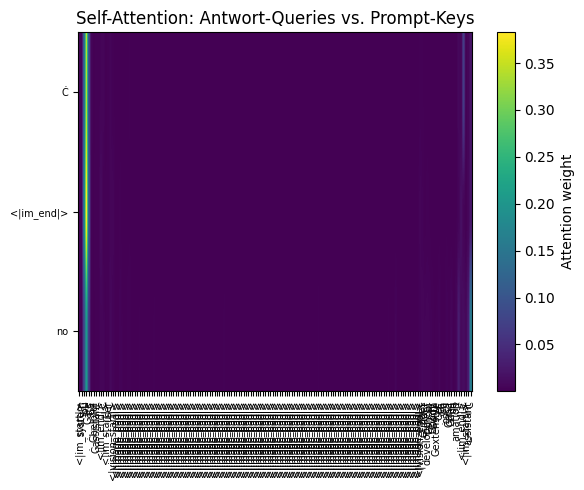

In [24]:
# Mittel über Heads, Cast auf float32, dann Numpy
attn_full = (
    out_full.attentions[-1][0]           # (heads, seq_full, seq_full)
    .mean(dim=0)                         # (seq_full, seq_full)
    .float()                             # Convert bfloat16 -> float32
    .detach()
    .cpu()
    .numpy()                             # float32 NumPy-Array
)


# 5) Tokens holen und splitten
ids_full    = inputs_full["input_ids"][0].cpu().tolist()
tokens_full = processor.tokenizer.convert_ids_to_tokens(ids_full)

# Prompt- und Antwort-Token-Listen
tokens_prompt = tokens_full[:prompt_len]
tokens_answer = tokens_full[prompt_len:]

# 6) Submatrix: Queries=Antwort, Keys=Prompt
attn_ans2prom = attn_full[prompt_len:, :prompt_len]   # shape (len(answer), len(prompt))

# 7) Plot
plt.figure(figsize=(6,5))
plt.imshow(attn_ans2prom, origin="lower", aspect="auto")
plt.colorbar(label="Attention weight")

plt.xticks(range(len(tokens_prompt)), tokens_prompt, rotation=90, fontsize=7)
plt.yticks(range(len(tokens_answer)), tokens_answer, rotation=0,  fontsize=7)

plt.title("Self-Attention: Antwort-Queries vs. Prompt-Keys")
plt.tight_layout()
plt.show()

In [25]:
tokens_answer

['no', '<|im_end|>', 'Ċ']

# Jetzt mit der generierten Antwort

In [26]:

gen_out = model.generate(
    **inputs,
    max_new_tokens=50,
    return_dict_in_generate=True
)
# Sequenzen holen und decodieren
seqs = gen_out.sequences  # Shape (1, seq_len_full)
decoded = processor.tokenizer.batch_decode(seqs, skip_special_tokens=True)
model_answer = decoded[0]
print("Generierte Antwort:", model_answer)


Generierte Antwort: system
You are a helpful assistant.
user
does underdevelopment show body with extensive ecchymoses and desquamation?
assistant
Yes, underdevelopment can be associated with extensive ecchymoses (bruising) and desquamation (peeling of the skin). These symptoms suggest a condition that affects the skin and underlying tissues, which could be indicative of various medical conditions.


In [27]:
messages_full = [
    {"role":"user",      "content":[{"type":"image","image":image},
                                     {"type":"text", "text":question}]},
    {"role":"assistant","content":[{"type":"text", "text": model_answer}]}
]


In [28]:
text_full = processor.apply_chat_template(
    messages_full,
    tokenize=False,
    add_generation_prompt=False
)
image_inputs, _ = process_vision_info(messages_full)
inputs_full = processor(
    text=[text_full],
    images=image_inputs,
    padding=True,
    return_tensors="pt"
).to(model.device)

out_full = model(
    **inputs_full,
    output_attentions=True,
    return_dict=True
)
attn_full = (
    out_full.attentions[-1][0]
    .mean(dim=0)
    .float()
    .detach()
    .cpu()
    .numpy()
)


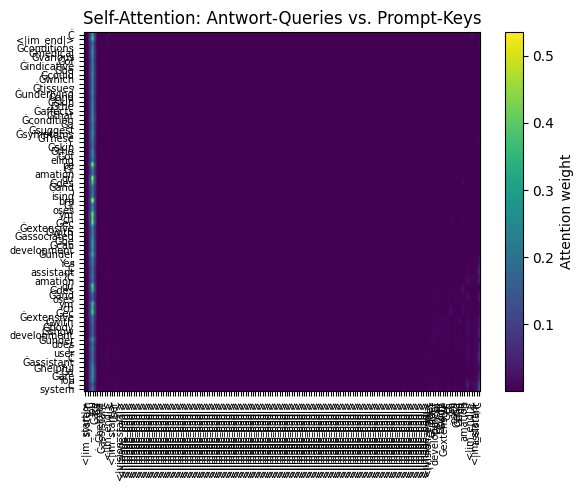

In [29]:
# Prompt-Länge wie gehabt
prompt_len = inputs["input_ids"].shape[1]

ids_full    = inputs_full["input_ids"][0].cpu().tolist()
tokens_full = processor.tokenizer.convert_ids_to_tokens(ids_full)
tokens_prompt = tokens_full[:prompt_len]
tokens_answer = tokens_full[prompt_len:]

attn_ans2prom = attn_full[prompt_len:, :prompt_len]

plt.figure(figsize=(6,5))
plt.imshow(attn_ans2prom, origin="lower", aspect="auto")
plt.colorbar(label="Attention weight")

plt.xticks(range(len(tokens_prompt)), tokens_prompt,
           rotation=90, fontsize=7)
plt.yticks(range(len(tokens_answer)), tokens_answer,
           rotation=0,  fontsize=7)
plt.title("Self-Attention: Antwort-Queries vs. Prompt-Keys")
plt.tight_layout()
plt.show()


Generierte Antwort: system
You are a helpful assistant.
user
does underdevelopment show body with extensive ecchymoses and desquamation?
assistant
Yes, underdevelopment can be associated with extensive ecchymoses (bruising) and desquamation (peeling of the skin). These symptoms suggest a condition that affects the skin and underlying tissues, which could be indicative of various medical conditions.


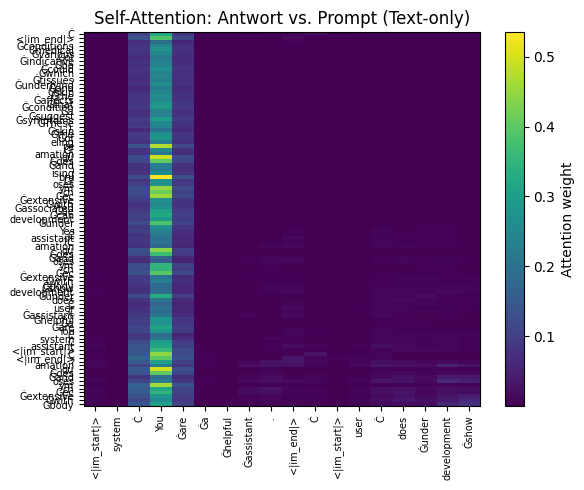

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Generiere erstmal die Antwort mit dem vollen Modell (inkl. Bild)
gen_out = model.generate(
    **inputs, 
    max_new_tokens=50, 
    return_dict_in_generate=True
)
seqs = gen_out.sequences
decoded = processor.tokenizer.batch_decode(seqs, skip_special_tokens=True)
model_answer = decoded[0]
print("Generierte Antwort:", model_answer)

# 2) Erzeuge jetzt nur ein reines Text-Prompt (ohne Bild) mit Prompt + Antwort
#    Keine {"type":"image"} mehr!
messages_text = [
    {"role": "user",      "content":[{"type":"text","text": question}]},
    {"role": "assistant", "content":[{"type":"text","text": model_answer}]}
]
text_full = processor.apply_chat_template(
    messages_text,
    tokenize=False,
    add_generation_prompt=False
)

# 3) Nur Text als Input vorbereiten
inputs_text = processor(
    text=[text_full],
    padding=True,
    return_tensors="pt"
).to(model.device)

# 4) Forward mit Attentions
out_text = model(
    **inputs_text,
    output_attentions=True,
    return_dict=True
)

# 5) Mitteln über Heads, Cast auf float32
attn_full = (
    out_text.attentions[-1][0]  # (heads, seq_full, seq_full)
    .mean(dim=0)                # (seq_full, seq_full)
    .float()
    .detach()
    .cpu()
    .numpy()
)

# 6) Tokens und Split-Index
ids_full      = inputs_text["input_ids"][0].cpu().tolist()
tokens_full   = processor.tokenizer.convert_ids_to_tokens(ids_full)
prompt_len    = len(processor.tokenizer.tokenize(question)) + 2  # +2 für System-/User-Tokens im Template
tokens_prompt = tokens_full[:prompt_len]
tokens_answer = tokens_full[prompt_len:]

# 7) Submatrix: Queries=Antwort, Keys=Prompt
attn_ans2prom = attn_full[prompt_len:, :prompt_len]

# 8) Plot
plt.figure(figsize=(6,5))
plt.imshow(attn_ans2prom, origin="lower", aspect="auto")
plt.colorbar(label="Attention weight")

plt.xticks(range(len(tokens_prompt)), tokens_prompt, rotation=90, fontsize=7)
plt.yticks(range(len(tokens_answer)), tokens_answer, rotation=0,  fontsize=7)

plt.title("Self-Attention: Antwort vs. Prompt (Text-only)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_4459/1243521040.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


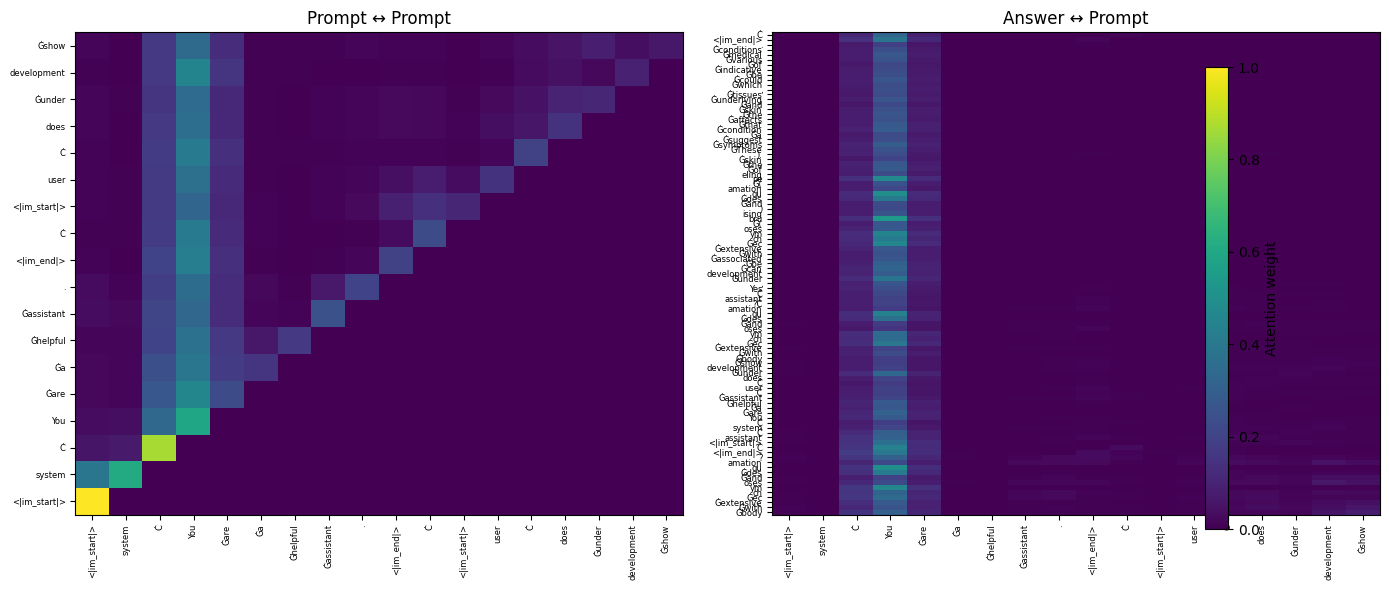

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Deine beiden Matrizen
attn_pp = attn_avg[:prompt_len, :prompt_len]      # Prompt ↔ Prompt
attn_ap = attn_full[prompt_len:, :prompt_len]     # Answer ↔ Prompt

tokens_pp  = tokens_full[:prompt_len]
tokens_ans = tokens_full[prompt_len:]

# 2) Gemeinsame Farbgrenzen
vmin = min(attn_pp.min(), attn_ap.min())
vmax = max(attn_pp.max(), attn_ap.max())

# 3) Subplots mit gemeinsamem Colorbar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prompt vs Prompt
im1 = ax1.imshow(attn_pp, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
ax1.set_title("Prompt ↔ Prompt")
ax1.set_xticks(range(len(tokens_pp)))
ax1.set_yticks(range(len(tokens_pp)))
ax1.set_xticklabels(tokens_pp, rotation=90, fontsize=6)
ax1.set_yticklabels(tokens_pp, fontsize=6)

# Answer vs Prompt
im2 = ax2.imshow(attn_ap, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
ax2.set_title("Answer ↔ Prompt")
ax2.set_xticks(range(len(tokens_pp)))
ax2.set_yticks(range(len(tokens_ans)))
ax2.set_xticklabels(tokens_pp, rotation=90, fontsize=6)
ax2.set_yticklabels(tokens_ans, rotation=0, fontsize=6)

# Gemeinsamer Colorbar rechts
cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label("Attention weight")

plt.tight_layout()
plt.show()



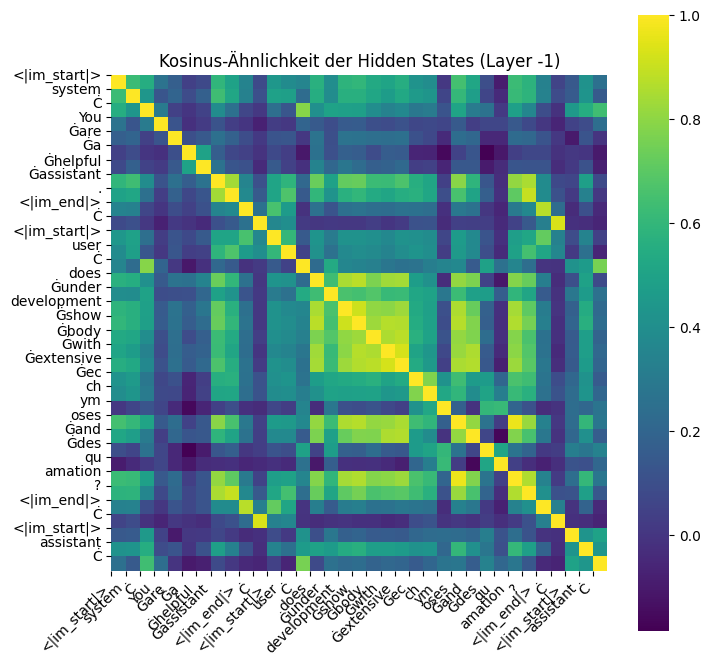

In [28]:
# Hidden States extrahieren
outputs = model(**inputs, output_hidden_states=True, return_dict=True)
hidden_states = outputs.hidden_states  # Liste von (batch_size, seq_len, hidden_size) für jeden Layer

# Kosinus-Ähnlichkeit für einen bestimmten Layer
layer = -1  # Letzter Layer
hidden = hidden_states[layer][0].detach().cpu().float()  # Shape: (seq_len, hidden_size)
cos_sim = torch.nn.functional.cosine_similarity(hidden.unsqueeze(1), hidden.unsqueeze(0), dim=-1).numpy()

# Visualisierung
plt.figure(figsize=(8, 8))
sns.heatmap(cos_sim, cmap="viridis", square=True)
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.yticks(range(len(tokens)), tokens)
plt.title(f"Kosinus-Ähnlichkeit der Hidden States (Layer {layer})")
plt.show()

In [30]:
hidden_states

(tensor([[[-0.0232,  0.0008, -0.0154,  ...,  0.0149,  0.0042,  0.0001],
          [-0.0308,  0.0371,  0.0289,  ..., -0.0188,  0.0061,  0.0212],
          [ 0.0330, -0.0216, -0.0021,  ..., -0.0209, -0.0210, -0.0383],
          ...,
          [-0.0232,  0.0008, -0.0154,  ...,  0.0149,  0.0042,  0.0001],
          [-0.0107, -0.0155, -0.0082,  ..., -0.0176,  0.0081,  0.0287],
          [ 0.0330, -0.0216, -0.0021,  ..., -0.0209, -0.0210, -0.0383]]],
        device='cuda:0', dtype=torch.bfloat16, grad_fn=<EmbeddingBackward0>),
 tensor([[[ 0.1426,  0.2891,  0.1562,  ..., -0.8203,  0.1211,  0.0674],
          [-0.2480,  0.4805,  0.5664,  ...,  0.2432,  0.1191, -0.1895],
          [-0.3594,  0.0303,  0.0977,  ...,  0.0952,  0.3613, -0.3203],
          ...,
          [ 0.3047, -0.0547,  0.4258,  ..., -0.6523, -0.1807,  0.4062],
          [ 0.2500,  0.1030, -0.1279,  ..., -0.3105, -0.3652,  0.5352],
          [-0.0581, -0.1807,  0.1245,  ...,  0.1582,  0.1504, -0.2393]]],
        device='cuda:0',